# Basic GRASP

The pseudo code for basic GRASP algorithm is outlined below.  Note that the TSP implementation in these notes always results in feasible solutions.  Optionally GRASP may include a **repair** function used to modify infeasible solutions created during the construction phase.

```python
def basic_grasp():
    best = []
    do 
        s = greedy_construction()
        s = local_search(s)

        if cost(s) > cost(best):
            best = s
    
    until max_iterations or time_limit
    
    return best
```

> The way I like to think about basic GRASP that it feeds the local search with a diverse set of high(ish) quality initial solutions.

## Imports

In [7]:
import numpy as np
import time

## `metapy` imports

In [ ]:
# uncomment if running in Google Colab
# !pip install meta-py

In [6]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber,
                                               TweakTwoOpt, 
                                               SimpleTweak)

from metapy.tsp.grasp import (SemiGreedyConstructor, FixedRCLSizer, 
                              RandomRCLSizer)

## Load problem

In [19]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Implementation

We will implement the algorithm in a `GRASP` class.  We will set the class up to accept the following parameters:

* Logic for the semi-greedy constructor. 
* The local search algorithm.
* Parameters that control the run duration.

In [9]:
class GRASP:
    '''
    Greedy Randomised Adaptive Search Procedure algorithm
    for the Travelling Salesman Problem.
    
    
    The class has the following properties
    .best: float
        the best cost
        
    .best_solution: np.ndarray
        the best tour found
    
    '''
    def __init__(self, constructor, local_search, max_iter=1000,
                 time_limit=np.inf):
        '''
        Constructor
        
        Parameters:
        ---------
        constructor: object
            semi-greedy construction heuristic
            
        local_search: object
            local search heuristic e.g. `HillClimber`
            
        max_iter: int, optional (default=1000)
            The maximum number of iterations (restarts) of GRASP
            
        time_limit: float64, optional (default=np.inf)
            The maximum allowabl run time.
            
        
        '''
        # semi greedy tour construction method
        self.constructor = constructor
        
        # local search procedure
        self.local_search = local_search
        
        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit
        
        # init solution 
        self.best_solution = None
        self.best = None
    
        
    def solve(self):
        '''
        Run GRASP
        
        Returns:
        -------
        None
        '''
        
        self.best_solution = None
        self.best = -np.inf
        
        i = 0
        start = time.time()
    
        while i < self.max_iter and ((time.time() - start) < self.time_limit):
            
            i += 1
            
            # construction phase
            solution = self.constructor.build()
            
            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()
            
            current_solution = self.local_search.best_solutions[0]
            current = self.local_search.best_cost
            
            # check if better than current solution
            if current > self.best:
                self.best = current
                self.best_solution = current_solution

## Running Basic GRASP

The function `get_grasp` is our recipe to bring together our GRASP ingredients into a the full algorithm.

In [29]:
def get_grasp(tour, matrix, max_iter=50, rcl_size=5, random_seed=None):
    '''
    Parameterises a basic grasp model
    
    Params:
    ------
    tour: np.array
        cities in tour as vector
        
    matrix: np.array
        matrix of costs
    
    max_iter: int, optional (default=50)
        The number of iterations (restarts) of GRASP
        
    rcl_size: int optional (default=5)
        if int then a FixedRCLSizer is used.  
        
    random_seed: int, optional (default=None)
        control the sampling of the semi-greedy constructor
        
    Returns:
    -------
    GRASP
        
    '''
    # objective function; optimised = numpy
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=rcl_size)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=random_seed)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running Basic GRASP.

** GRASP OUTPUT ***
best cost:	-754.0
best solutions:
[ 0 35 22 15 46 36 57 49 50 55 64 63 10 47 66 32 53 61 33 20 11 59 51  9
  4 52 17 41  5 40 42 16  8 39 60 38 24 44 45 26 67 43 29 19 13 48 54 25
  7 27  2 31  3  1  6 18 23 34 68 30 69 28 12 37 58 21 65 62 56 14]


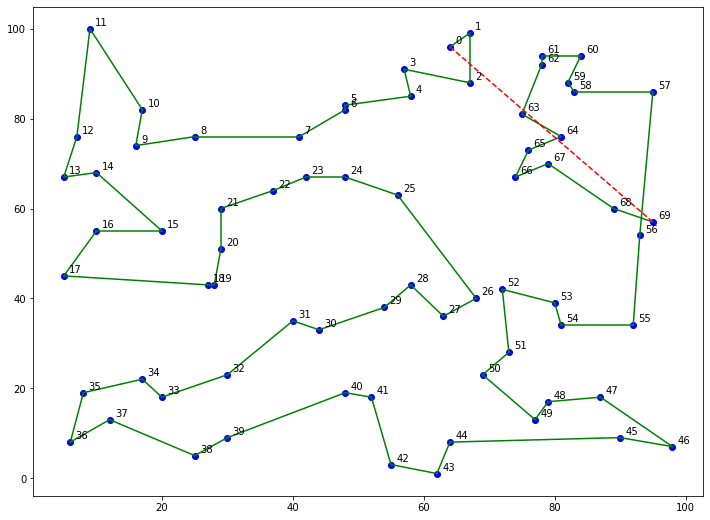

In [31]:
tour = np.arange(70)
solver = get_grasp(tour, matrix, random_seed=42)
print("\nRunning Basic GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f'best cost:\t{solver.best}')
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))